# Cell identification and Segmentation
0.- Preprocessing

1.- Identify Cells: Blurr image to identify local maximum. The blurring lets us focus only on large structures i.e. cells

2.- Identigy Nucleus: Use the Chan and Vese method to grow the area and locate the nucleus

3.- Identify Cito: Use wavelet analysis to identify the outline. (Harr wavelets)


In [4]:
import numpy as np
import cv2 as cv
import gwyfile as gwy
import os
import utils
import matplotlib.pyplot as plt


## 0 - Preprocess

Text(0.5, 1.0, '(457, 377)')

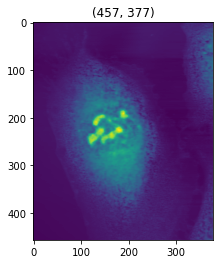

In [5]:
#gwyobj1 = gwy.load(os.getcwd()+ "/data/ctrl_2_1.gwy")
#gwyobj1 = gwy.load(os.getcwd()+ "/data/U2_ctrl9_cell1.gwy")
#gwyobj1 = gwy.load(os.getcwd()+ "/data/U2_ctrl_5_cell1.gwy")

gwyobj1 = gwy.load(os.getcwd()+ "/data/U2_ctrl_5_cell2.gwy")

img0  = utils.get_Top(gwyobj1)


plt.imshow(img0 )
plt.title(f"{img0.shape}")

## 1.- Cell Identification w/ Hessian
The idea is to get a broad picture of where the cell is located in the image.

        a) Resize image
        b) Gaussian Blurring (define kernel size)
        c) Calculate Hessian
        d) Apply condition over hessian (finds cells)

In [55]:
#
# a) Resize
#

shrink = 0.1
nx =  int(shrink* img0.shape[1])
ny =  int(shrink* img0.shape[0])

imgT = cv.resize( img0,(ny,nx),interpolation = cv.INTER_CUBIC)
#
# b) blurr
#
blurr_nsize = 21
blurred = cv.GaussianBlur(imgT,(blurr_nsize,blurr_nsize),0 )

#
# c) Hessian
#
eigmat = utils.hessian_eigen(utils. hessian( blurred ))

#
# d) conditions over hessians
#
seed_mask = np.logical_and( eigmat[0] < 0 , eigmat[1] <0)
seed_mask = utils.keepLargestArea(seed_mask)
#temp = cv.morphologyEx(np.uint8(temp),cv.MORPH_OPEN,np.ones((2,2),np.uint8) )

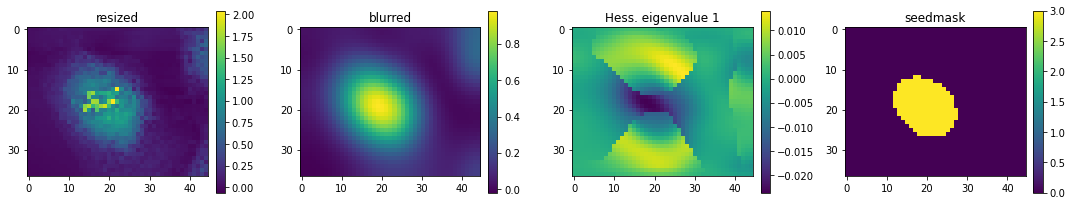

In [56]:
cellid_list= [imgT,blurred,eigmat[0],seed_mask]
titles     = ["resized","blurred","Hess. eigenvalue 1","seedmask"]

plt.figure(figsize=(15, 5))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(cellid_list[i])
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"{titles[i]}")
plt.tight_layout()




## 2.- Identify Nucleus

    a) resize "core mask" and "img0" to about half of the orginal size. (of img0)
    b) apply Chan Vese starting with "core_mask"
    

In [58]:
import chanvese as cv_seg
#
# a) Resize
#
shrink = 0.4
nx =  int(shrink* img0.shape[1])
ny =  int(shrink* img0.shape[0])

mask0 = cv.resize( seed_mask.astype(np.uint8), (ny,nx),interpolation = cv.INTER_CUBIC)
mask0 = np.where( mask0 > 0, 1,0)

imgT = cv.resize( img0,(ny,nx),interpolation = cv.INTER_CUBIC)

#
# b) Chan Vese
#coeff[0] > val 

#from scipy.ndimage import generic_filter
#dx = utils.get_dx(gwyobj1)
#n2microns = int(2/dx)
#rmsgrid  = generic_filter(imgT, np.std, size=(n2microns,n2microns),  mode = "nearest")
#rmsgrid = cv.resize( rmsgrid,(ny,nx),interpolation = cv.INTER_CUBIC)

nucleus_mask = cv_seg.chanvese(imgT,   mask0, max_its=600, alpha=0.01)


iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550


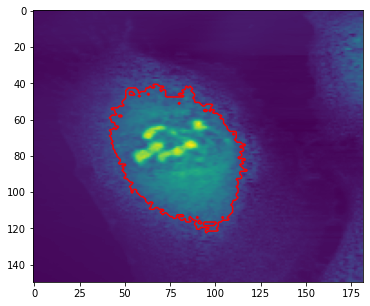

In [59]:
fig, axs = plt.subplots( figsize=(10, 5))
axs.imshow(imgT )
axs.contour(nucleus_mask[0], colors = "r")

# Identify Cell by wavelet analysis

In [97]:
img_lapl = cv.Laplacian( imgT, cv.CV_64F ) 

In [99]:
import pywt
from skimage import filters

filter_img = img_lapl
coeff =  pywt.wavedec2( filter_img , 'haar', level=1)
cH_photo,cV_photo,cD_photo = coeff[1]
img_wavelets = cv.resize( coeff[0], (ny,nx),interpolation = cv.INTER_CUBIC)



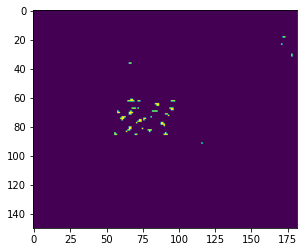

In [100]:
val = filters.threshold_otsu( img_wavelets )
plt.imshow(img_wavelets > val)

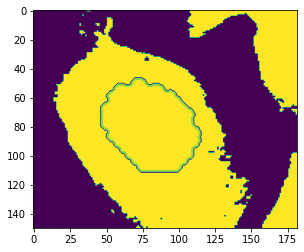

In [82]:
plt.imshow( cell_mask > 0.15*val )
plt.contour(mask0)

(array([ 50., 403., 753., 731., 700., 562., 397., 330., 295., 197., 186.,
        152., 123., 119., 110.,  87.,  72.,  65.,  71.,  63.,  49.,  51.,
         50.,  47.,  50.,  46.,  48.,  44.,  39.,  45.,  34.,  44.,  30.,
         49.,  41.,  46.,  31.,  29.,  32.,  29.,  36.,  28.,  34.,  34.,
         31.,  26.,  24.,  16.,  27.,  14.,  21.,  26.,  18.,  20.,  22.,
         14.,   9.,   9.,   7.,   9.,   5.,   8.,   8.,   0.,   3.,   4.,
          1.,   3.,   3.,   5.,   1.,   2.,   3.,   1.,   3.,   4.,   2.,
          0.,   2.,   3.,   1.,   7.,   6.,   3.,   2.,   0.,   3.,   2.,
          2.,   2.,   1.,   2.,   3.,   1.,   2.,   0.,   0.,   0.,   1.,
          1.]),
 array([-1.24321810e-01, -8.27042469e-02, -4.10866837e-02,  5.30879425e-04,
         4.21484426e-02,  8.37660057e-02,  1.25383569e-01,  1.67001132e-01,
         2.08618695e-01,  2.50236258e-01,  2.91853821e-01,  3.33471385e-01,
         3.75088948e-01,  4.16706511e-01,  4.58324074e-01,  4.99941637e-01,
         5.415

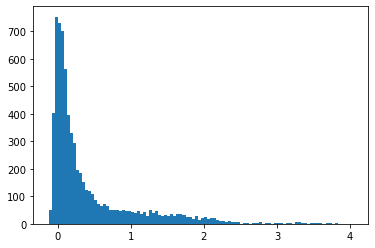

In [87]:
plt.hist(coeff[0].ravel(), bins = 100 )

In [86]:
coeff[0].ravel() 

array([0.0319271 , 0.02765824, 0.02564565, ..., 0.72433094, 0.60628895,
       0.569639  ])